In [1]:
import numpy as np
import pandas as pd
import gc
import os
import shutil

from astropy.io import fits

from tqdm import tqdm


## Reformat the SHARK catalogs

In [2]:
# First we load the SHARK catalog containing the source fluxes
file_path_1 = '/mnt/f/Datasets/MSc Thesis/simulation catalogs/Shark-deep-opticalLightcone-AtLAST-FIR.txt'
shark_cat_fluxes = pd.read_csv(file_path_1,
                   sep=r'\s+|\t',  # Use a regular expression for multiple delimiters
                   header=None,
                   engine='python',
                   skiprows=8,
                   names=["SMIPS24", "SSPIRE250", "SSPIRE350", "SSPIRE500"],  # Add missing quotes and correct column names
                   usecols=[0, 4, 5, 7],  # Correct column indices (0-based indexing)
                   chunksize=2500000)

shark_cat_fluxes = pd.concat(shark_cat_fluxes)/1000 # conversion to Jy

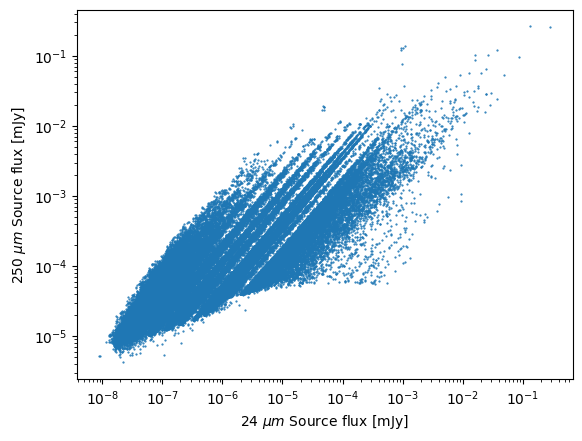

In [3]:
from matplotlib import pyplot as plt
plt.scatter(shark_cat_fluxes["SMIPS24"][:100000], shark_cat_fluxes["SSPIRE500"][:100000], s=0.3)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"24 $\mu m$ Source flux [mJy]")
plt.ylabel(r"250 $\mu m$ Source flux [mJy]")
plt.show()

In [4]:
# First we load the SHARK catalog containing the source positions
file_path_2 = '/mnt/f/Datasets/MSc Thesis/simulation catalogs/Shark-deep-opticalLightcone-AtLAST.txt'
shark_cat_pos = pd.read_csv(file_path_2,
                   sep=r'\s+|\t',  # Use a regular expression for multiple delimiters
                   header=None,
                   engine='python',
                   skiprows=12,
                   names=["dec", "ra"],  # Add missing quotes and correct column names
                   usecols=[0, 1],  # Correct column indices (0-based indexing)
                   chunksize=5000000)

shark_cat_pos = pd.concat(shark_cat_pos)

In [5]:
shark_cat_fluxes

,SMIPS24,SSPIRE250,SSPIRE350,SSPIRE500
0,9.530000e-08,0.000040,0.000065,0.000077
1,3.980000e-08,0.000004,0.000007,0.000009
2,3.610000e-08,0.000014,0.000023,0.000029
3,2.810000e-08,0.000004,0.000007,0.000009
4,5.150000e-08,0.000012,0.000020,0.000023
...,...,...,...,...
33503464,3.156600e-06,0.000139,0.000152,0.000122
33503465,1.936400e-06,0.000092,0.000096,0.000074
33503466,1.379840e-05,0.000616,0.000674,0.000537
33503467,1.600500e-06,0.000063,0.000075,0.000063


In [6]:
ra_min = np.min(shark_cat_pos["ra"])
ra_max = np.max(shark_cat_pos["ra"])

dec_min = np.min(shark_cat_pos["dec"])
dec_max = np.max(shark_cat_pos["dec"])

In [7]:
ra_min, ra_max, dec_min, dec_max

(211.5, 223.5, -4.5, 4.5)

In [8]:
merged_cat = pd.concat([shark_cat_pos, shark_cat_fluxes], axis=1)

In [9]:
merged_cat['SSPIRE500']

0           0.000077
1           0.000009
2           0.000029
3           0.000009
4           0.000023
              ...   
33503464    0.000122
33503465    0.000074
33503466    0.000537
33503467    0.000063
33503468    0.000062
Name: SSPIRE500, Length: 33503469, dtype: float64

In [10]:
# Replace 'output_file.fits' with the desired file name and path
output_file = '/mnt/d/SRHerschel500/data/raw/catalogs/sim/SHARK_CAT.fits'

# Convert the DataFrame to an Astropy Table
table = fits.BinTableHDU.from_columns([fits.Column(name=name, format='D', array=merged_cat[name]) for name in merged_cat.columns if name != "index"])

# Write the table to the FITS file
table.writeto(output_file, overwrite=True)

## Code to split SHARK catalog into multiple catalogs of 2 sq deg

In [13]:
shark_cat = fits.getdata('/mnt/d/SRHerschel500/data/raw/catalogs/sim/SHARK_CAT.fits')
shark_cat = pd.DataFrame(shark_cat)

# Convert all columns to little-endian format
shark_cat = shark_cat.astype('<f8')

In [14]:
shark_cat

,dec,ra,SMIPS24,SSPIRE250,SSPIRE350,SSPIRE500
0,3.407255,217.480743,9.530000e-08,0.000040,0.000065,0.000077
1,0.801156,219.899841,3.980000e-08,0.000004,0.000007,0.000009
2,0.628279,219.771744,3.610000e-08,0.000014,0.000023,0.000029
3,0.647418,219.761307,2.810000e-08,0.000004,0.000007,0.000009
4,-0.524088,219.828049,5.150000e-08,0.000012,0.000020,0.000023
...,...,...,...,...,...,...
33503464,-1.241381,213.557129,3.156600e-06,0.000139,0.000152,0.000122
33503465,-1.255116,213.384628,1.936400e-06,0.000092,0.000096,0.000074
33503466,-1.247245,213.362732,1.379840e-05,0.000616,0.000674,0.000537
33503467,-1.254189,213.356705,1.600500e-06,0.000063,0.000075,0.000063


In [15]:
center_coords = [(i, j) for i in np.arange(213, 213 + 2*3, 2) for j in np.arange(-3.5, -3.5 + 2*4, 2)] # 3x4 grid center coordinates
output_fits = lambda i: f'/mnt/d/SRHerschel500/data/raw/catalogs/sim/SHARK_cat{i}.fits'
ra_dec_width = np.sqrt(2) # in degrees

for i, center in tqdm(enumerate(center_coords)):
    cat_slice = shark_cat[(center[0] - ra_dec_width/2) <= shark_cat["ra"]]
    cat_slice = cat_slice[cat_slice["ra"] <= (center[0] + ra_dec_width/2)]
    cat_slice = cat_slice[(center[1] - ra_dec_width/2) <= cat_slice["dec"]]
    cat_slice = cat_slice[cat_slice["dec"] <= (center[1] + ra_dec_width/2)].reset_index(drop=True)

    cat_slice.replace([np.inf, -np.inf], 0, inplace=True)

    # Check area of catalog
    print(f"AREA OF CATALOG {i+1} = {(np.max(cat_slice['ra']) - np.min(cat_slice['ra'])) * (np.max(cat_slice['dec']) - np.min(cat_slice['dec']))}")

    # Convert the DataFrame to an Astropy Table
    table = fits.BinTableHDU.from_columns([fits.Column(name=name, format='D', array=cat_slice[name]) for name in cat_slice.columns if name != "index"])

    # Create an empty PrimaryHDU (image HDU)
    empty_image_hdu = fits.PrimaryHDU()

    # Create an HDUList and add both HDUs to it
    hdul = fits.HDUList([empty_image_hdu, table])

    # Write the table to the FITS file
    hdul.writeto(output_fits(i+1), overwrite=True)


0it [00:00, ?it/s]

AREA OF CATALOG 1 = 1.9999523901463012


2it [00:02,  1.05s/it]

AREA OF CATALOG 2 = 1.9999411793395379


3it [00:03,  1.10it/s]

AREA OF CATALOG 3 = 1.9999532540716551


4it [00:03,  1.23it/s]

AREA OF CATALOG 4 = 1.999951547150878


5it [00:04,  1.34it/s]

AREA OF CATALOG 5 = 1.9999368800647155


6it [00:04,  1.42it/s]

AREA OF CATALOG 6 = 1.9999503671552732


7it [00:05,  1.49it/s]

AREA OF CATALOG 7 = 1.9999542867092284


8it [00:06,  1.56it/s]

AREA OF CATALOG 8 = 1.9999523901463012


9it [00:06,  1.64it/s]

AREA OF CATALOG 9 = 1.9999557618451527


10it [00:07,  1.64it/s]

AREA OF CATALOG 10 = 1.9999551718473507


11it [00:07,  1.70it/s]

AREA OF CATALOG 11 = 1.999956056844055


12it [00:08,  1.44it/s]

AREA OF CATALOG 12 = 1.9999525587171014


### Ensure that the flux columns of the SPRITZ data have the same names
#### Only run once

In [ ]:
# cat = pd.DataFrame(fits.getdata(f"CATALOGS/SPRITZ_to_gen_maps.fits", memmap=False)).astype('<f8')

# # Merge all simulation catalogs together, ensuring the same column names are used
# cols = ["ra", "dec", "SMIPS24", "SSPIRE250", "SSPIRE350", "SSPIRE500"]

# cat = cat[["ra", "dec", "Spitzer_MIPS_24mu", "SHerschel_SPIRE_250", "SHerschel_SPIRE_350", "SHerschel_SPIRE_500"]]
# cat.columns = cols


# # Convert the DataFrame to an Astropy Table
# table = fits.BinTableHDU.from_columns([fits.Column(name=name, format='D', array=cat[name]) for name in cat.columns if name != "index"])

# # Create an empty PrimaryHDU (image HDU)
# empty_image_hdu = fits.PrimaryHDU()

# # Create an HDUList and add both HDUs to it
# ## This is the HDUList cosntruction that SIDES uses, and hence we do it as well to be sure since we use SIDES to generate the maps
# hdul = fits.HDUList([empty_image_hdu, table])

# # Write the table to the FITS file
# hdul.writeto(f"CATALOGS/SPRITZ_to_gen_maps.fits", overwrite=True)

#### Merge all catalogs into one simulation catalog and offset SIDES due to SPRITZ covering the same area on the sky
#### Only run once, otherwise the SIDES coordinates keeps increasing (in sync with catalog) risking overlap with other catalogs
#### Replacing SIDES datamaps with the original once, or setting the CRVAL values back to the original values fixes it

In [16]:
base_project_path = r"/mnt/d/SRHerschel500"
raw_data_path = os.path.join(base_project_path, "data/raw")

SIDES_instrument_l = ["MIPS24", "SPIRE250", "SPIRE350", "SPIRE500", "SR_SPIRE500"]
catalog_paths_SHARK = [f"SHARK_cat{i+1}.fits" for i in range(12)]
catalog_paths_SIDES = [f"SIDES_cat{i+1}.fits" for i in range(12)]
catalog_paths_SPRITZ = [f"SPRITZ_to_gen_maps.fits"]
catalog_paths = catalog_paths_SHARK + catalog_paths_SIDES + catalog_paths_SPRITZ
SIDES_offsets = [(i, 0) for i in np.arange(20, 20 + 12*2, 2)] # prevent conflicts with other catalogs

In [3]:
for idx, catalog_path in tqdm(enumerate(catalog_paths_SIDES)):
    cat_path = os.path.join(raw_data_path, f"catalogs/sim/{catalog_paths_SIDES[idx]}")
    with fits.open(cat_path, memmap=False, mode='update') as cat:
        # Offset SIDES catalog coordinates, and overwrite existing catalog file
        cat_data = pd.DataFrame(cat[1].data).astype('<f8')[["ra", "dec", "SMIPS24", "SSPIRE250", "SSPIRE350", "SSPIRE500"]]
        cat_data["ra"] += SIDES_offsets[idx][0]
        cat_data["dec"] += SIDES_offsets[idx][1]
        cat[1].data = cat_data.to_records(index=False)
        cat.flush()  # Perform the update

    for instr_idx, instrument in enumerate(SIDES_instrument_l):
        fits_path = os.path.join(raw_data_path, f"sim datamaps/SIDES_{idx+1}_{SIDES_instrument_l[instr_idx]}_smoothed_Jy_beam.fits")
        with fits.open(fits_path, mode='update') as hdu:
            hdu[0].header["CRVAL1"] += SIDES_offsets[idx][0]  # degrees
            hdu[0].header["CRVAL2"] += SIDES_offsets[idx][1]  # degrees
            hdu.flush()  # Perform the update

19it [02:54,  9.18s/it]


In [17]:
import time

for idx in range(len(catalog_paths)):
    hdu = fits.open(os.path.join(raw_data_path, f"catalogs/sim/{catalog_paths[idx]}"), memmap=False)
    df = pd.DataFrame(hdu[1].data.copy()).astype('<f8')[["ra", "dec", "SMIPS24", "SSPIRE250", "SSPIRE350", "SSPIRE500"]]

    if idx ==0:
        global_cat = df
    else:
        global_cat = pd.concat([global_cat, df], ignore_index=True, copy=False)
    print(idx, "Rows:", df.shape[0], "Total MB: ", np.sum(df.memory_usage(deep=True)/1e6), "No fluxes: ", np.sum((df["SSPIRE500"] <= 1e-5) & (df["SMIPS24"] <= 1e-7)))
    hdu.close()

    # Ensure all references are gone
    del hdu[1].data;
    del hdu;
    
    # Manual garbage collection
    gc.collect()


print(global_cat.memory_usage(deep=True)/1e6)



0 Rows: 626296 Total MB:  30.062336 No fluxes:  6441
1 Rows: 615641 Total MB:  29.550896 No fluxes:  6432
2 Rows: 625027 Total MB:  30.001424 No fluxes:  6475
3 Rows: 623626 Total MB:  29.934176 No fluxes:  6491
4 Rows: 628426 Total MB:  30.164576000000004 No fluxes:  6567
5 Rows: 624282 Total MB:  29.965664 No fluxes:  6404
6 Rows: 624957 Total MB:  29.998064 No fluxes:  6428
7 Rows: 626072 Total MB:  30.051584 No fluxes:  6374
8 Rows: 626428 Total MB:  30.068672 No fluxes:  6269
9 Rows: 604418 Total MB:  29.012192 No fluxes:  6202
10 Rows: 620566 Total MB:  29.787295999999998 No fluxes:  6487
11 Rows: 618194 Total MB:  29.67344 No fluxes:  6664
12 Rows: 5584998 Total MB:  268.08003199999996 No fluxes:  3592823
13 Rows: 5584998 Total MB:  268.08003199999996 No fluxes:  3593666
14 Rows: 5584998 Total MB:  268.08003199999996 No fluxes:  3593073
15 Rows: 5584998 Total MB:  268.08003199999996 No fluxes:  3593386
16 Rows: 5584998 Total MB:  268.08003199999996 No fluxes:  3594066
17 Rows: 5

In [18]:
cols = []

for name in global_cat.columns:
    cols.append(fits.Column(name=name, format='E', array=global_cat[name]))

# Convert the DataFrame to an Astropy Table
table = fits.BinTableHDU.from_columns(cols)

# Create an empty PrimaryHDU (image HDU)
empty_image_hdu = fits.PrimaryHDU()

# Create an HDUList and add both HDUs to it
hdul = fits.HDUList([empty_image_hdu, table])

# Write the table to the FITS file
hdul.writeto(os.path.join(raw_data_path, f"catalogs/sim/simulation_catalog.fits"), overwrite=True)

In [19]:
# Method 2: Using readlines() to read the first n lines (e.g., 5 lines)
n_lines_to_read = 30
with open(file_path_1, "r") as file:
    for i in range(n_lines_to_read):
        line = file.readline()
        print(line.strip())  # Use strip() to remove the trailing newline character


#Galaxies from Shark (Lagos et al. 2018) in the optical-deep lightcone
#SED modelling as described in Lagos et al. (2019).
#area 107.889 deg2
#S_850microns > 0.01 milli Jy
#units
#fluxes in units of mJy
#
#flux_24mu_Spitzer flux_P70_Herschel flux_P100_Herschel flux_P160_Herschel flux_S250_Herschel flux_S350_Herschel flux_S450_JCMT flux_S500_Herschel flux_S850_JCMT flux_Band7_ALMA flux_Band6_ALMA flux_Band5_ALMA flux_Band4_ALMA flux_Band3_ALMA
0.0000953 0.0018791 0.0035641 0.0116849 0.0397939 0.0654424 0.0742293 0.0766758 0.0928464 0.0923152 0.0806042 0.0806042 0.0333273  0.0115908
0.0000398 0.0003418 0.0005296 0.0012232 0.0040480 0.0069145 0.0083305 0.0092278 0.0155510 0.0159639 0.0150223 0.0150223 0.0065123  0.0022772
0.0000361 0.0009100 0.0015331 0.0041791 0.0140023 0.0234304 0.0273977 0.0294051 0.0430477 0.0436417 0.0399418 0.0399418 0.0170235  0.0057624
0.0000281 0.0003224 0.0005158 0.0012748 0.0042411 0.0071821 0.0085522 0.0093658 0.0149130 0.0152332 0.0141821 0.0141821 0.0061081 